## Problem Statement

Build a CNN prediction model that can accuratly detect melanoma.

## Import necessary libs

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Rescaling
# from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
# from keras.utils.np_utils import to_categorical

## Data Reading/Data Understanding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
path = "Skin cancer ISIC The International Skin Imaging Collaboration"

In [4]:
## ===== If using google colab, run this part =====

# from google.colab import drive
# drive.mount('/content/drive')

# path = "/content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration"

In [4]:
data_dir_train = pathlib.Path(path + "/Train/")
data_dir_test = pathlib.Path(path + "/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Dataset Creation

In [6]:
# Rules provided
#
image_width = 180
image_height = 180
batch_size = 32
seed = 123
validation_split = 0.2

In [7]:
# We will use `subset = 'both'` so that both training and validation sets are returned in one call
#
train_ds, validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size = batch_size,
    image_size = (image_height, image_width),
    seed = seed,
    validation_split = validation_split,
    subset = 'both',
    label_mode = 'categorical'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


Let us verify the cardinality of train and validation datasets. Each record is a batch of 32 images, so we multiply the cardinality with the batch size to get the actual number of images.

In [8]:
print(train_ds.cardinality().numpy() * batch_size)
print(validation_ds.cardinality().numpy() * batch_size)

1792
448


We have got correct number of images in each dataset.

In [9]:
# Storing all class names in a list
#
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Dataset Visualisation

Let us visualize one image of all the nine classes.

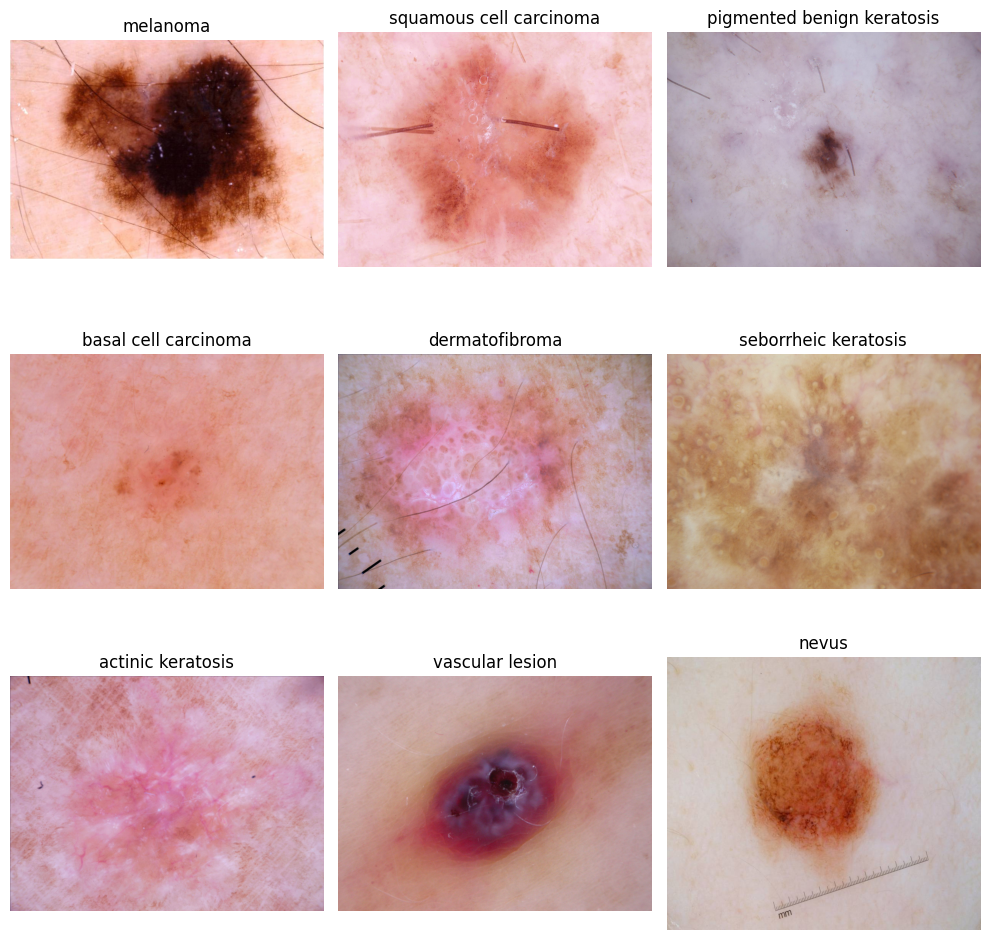

In [10]:
import os
import matplotlib.pyplot as plt
import random

# We will randomly select one image from each subdirectory under the Train dataset.
#
main_directory = path + "/Train/"
subdirectories = [subdir for subdir in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, subdir))]

# Plot one image from each subdirectory
#
fig, axes = plt.subplots(3, 3, figsize = (10, 10))
axes = axes.flatten()

for i, subdir in enumerate(subdirectories):
    # Get the list of image files in the subdirectory
    #
    image_files = [f for f in os.listdir(os.path.join(main_directory, subdir)) if f.endswith('.jpg')]

    # Select a random image from the subdirectory
    #
    random_image = random.choice(image_files)

    # Load and plot the image
    #
    image_path = os.path.join(main_directory, subdir, random_image)
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(subdir)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Model Building & Training

**NOTE**: The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
# Build a sequential model so that we can added layers
#
model = Sequential()

# Rescaling the inputs between 0 and 1
model.add(Rescaling(1./255, input_shape = (180, 180, 3)))

# First Convulation layer
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(MaxPool2D(pool_size = (2, 2)))

# # Second Convulation Layer
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

# # Third Convulation Layer
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = "same"))
# model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

# Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))

# Flatten Layer
# Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
# model.add(layers.Flatten())

# Dense Layer
# model.add(Dense(512, activation = 'relu'))

# Dropout layer with 25% Fraction of the input units to drop.
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))

# Dense Layer with softmax activation function.
# Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(len(class_names), activation = 'softmax'))

In [13]:
# We will use ADAM optimizer, since it converges rapidly and efficiently than
# other optimizers
optimizer = 'adam'

# We will use Binary CrossEntropy Loss function, which is ideally used for
# multiple categorical classification.
loss_fn = "categorical_crossentropy"

model.compile(
  optimizer = optimizer,
  loss = loss_fn,
  metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        36928     
                                                        

In [14]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size = batch_size,
  validation_data = validation_ds,
  epochs = epochs
)

Epoch 1/20
56/56 [==============================] - 616s 7s/step - loss: 4.2275 - accuracy: 0.2299 - val_loss: 18.6650 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 352s 6s/step - loss: 2.0443 - accuracy: 0.2266 - val_loss: 7.0735 - val_accuracy: 0.1588
Epoch 3/20
56/56 [==============================] - 326s 6s/step - loss: 2.0011 - accuracy: 0.2835 - val_loss: 5.7697 - val_accuracy: 0.1365
Epoch 4/20
56/56 [==============================] - 350s 6s/step - loss: 1.9297 - accuracy: 0.3041 - val_loss: 11.1970 - val_accuracy: 0.1767
Epoch 5/20
56/56 [==============================] - 392s 7s/step - loss: 1.9620 - accuracy: 0.2879 - val_loss: 2.7030 - val_accuracy: 0.2595
Epoch 6/20
56/56 [==============================] - 383s 7s/step - loss: 1.9130 - accuracy: 0.2829 - val_loss: 2.6023 - val_accuracy: 0.2125
Epoch 7/20
56/56 [==============================] - 328s 6s/step - loss: 1.8787 - accuracy: 0.3047 - val_loss: 3.4390 - val_accuracy: 0.1477
Epoch 8/20


### Visualizing training results

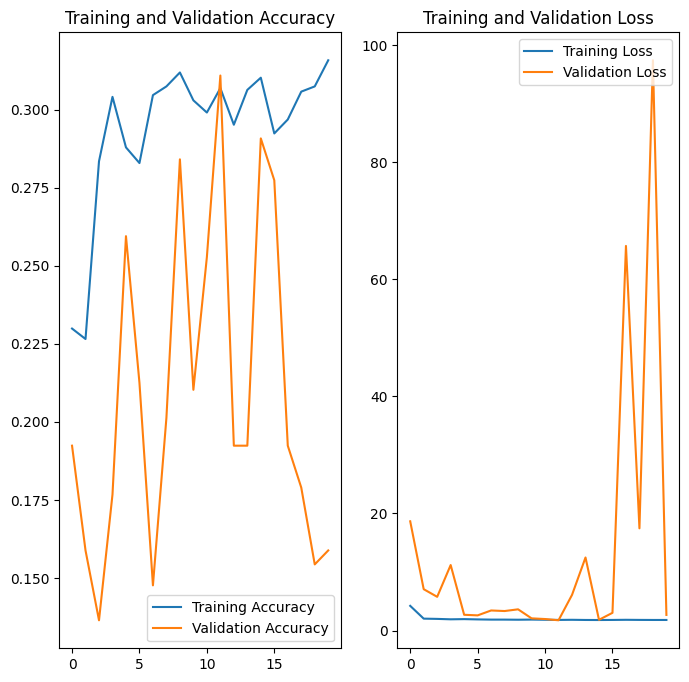

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inferences**
1. Both Training and Validation Accuracy are close but their value is too less, suggesting **Underfitting**.

Model accuracy is very low. We need to do some transformation to images and check if that would improve the accuracy of the model.

In [16]:
# We will do some image transformations.
#
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

data_augmentation = tf.keras.Sequential([
    # Randomly flip images during training
    RandomFlip("horizontal_and_vertical", input_shape = (image_height, image_width, 3)),
    # This layer will randomly rotate the image by a factor of up to 0.2 radians
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.1)
])

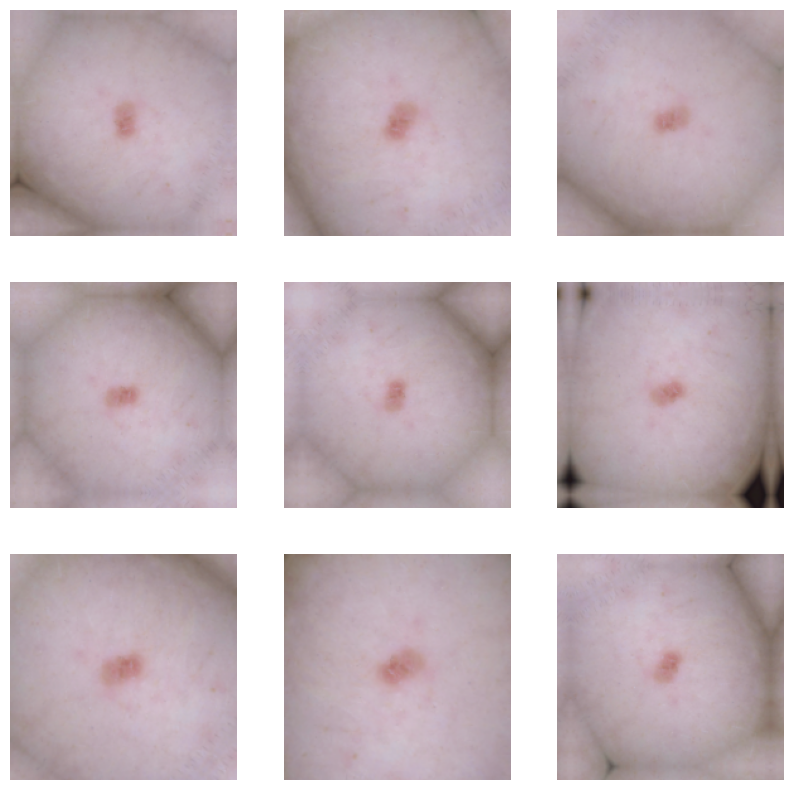

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

We can see that the same image looks randomply flipped, or zoomed in. Our augmentation strategy works. We will now build the model including data augmentation layers.

### Model after data augmentation

In [18]:
model = Sequential()

model.add(Rescaling(1./255, input_shape = (180, 180, 3)))
# Add the data augmentation strategy we built
model.add(data_augmentation)

# First Convulation layer
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(MaxPool2D(pool_size = (2, 2)))

# # Second Convulation Layer
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

# # Third Convulation Layer
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = "same"))
# model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

# Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))

# Flatten Layer
# Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
# model.add(layers.Flatten())

# Dense Layer
# model.add(Dense(512, activation = 'relu'))

# Dropout layer with 25% Fraction of the input units to drop.
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))

# Dense Layer with softmax activation function.
# Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(len(class_names), activation = 'softmax'))

### Compile the new model

In [19]:
model.compile(
  optimizer = optimizer,
  loss = loss_fn,
  metrics = ['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model

We will also use some learning rate control strategy.

In [20]:
learn_control = ReduceLROnPlateau(
    monitor = 'val_accuracy', patience = 5, verbose = 1, factor = 0.2, min_lr = 1e-7
)

In [21]:
epochs = 20
batch_size = 32

history = model.fit(
    train_ds,
    batch_size = batch_size,
    validation_data = validation_ds,
    epochs = epochs,
    callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 359s 6s/step - loss: 3.6024 - accuracy: 0.1942 - val_loss: 4.8647 - val_accuracy: 0.0537 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 354s 6s/step - loss: 2.1746 - accuracy: 0.1886 - val_loss: 13.8323 - val_accuracy: 0.0537 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 333s 6s/step - loss: 2.1250 - accuracy: 0.2143 - val_loss: 19.7368 - val_accuracy: 0.0537 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 340s 6s/step - loss: 2.1324 - accuracy: 0.2104 - val_loss: 12.0328 - val_accuracy: 0.0537 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 358s 6s/step - loss: 2.1196 - accuracy: 0.2070 - val_loss: 8.9905 - val_accuracy: 0.0537 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 335s 6s/step - loss: 2.0973 - accuracy: 0.2243 - val_loss: 3.3433 - val_accuracy: 0.1119 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 353s 6s/step - loss: 

### Visualizing scores

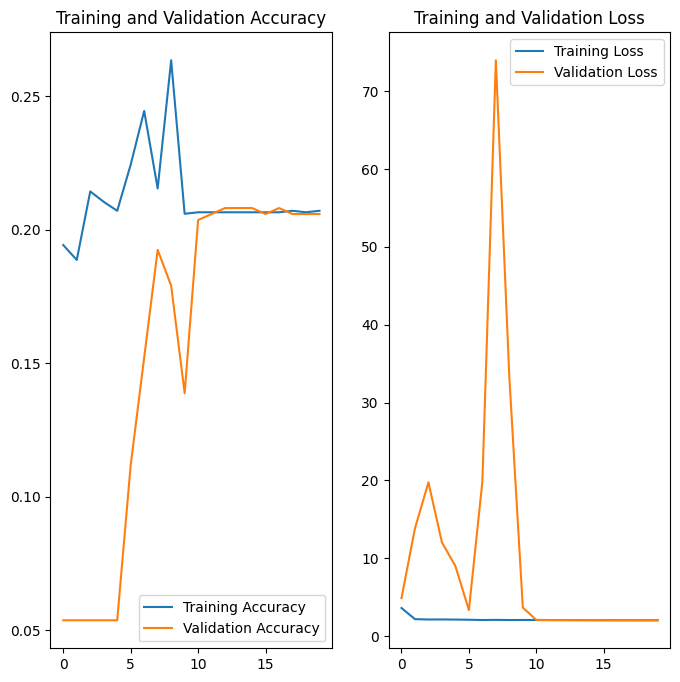

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

Since the model's accuracy is still very low, we need to check if there is class imbalance, i.e. data of one kind dominates other kinds.

### Visualizing data distribution

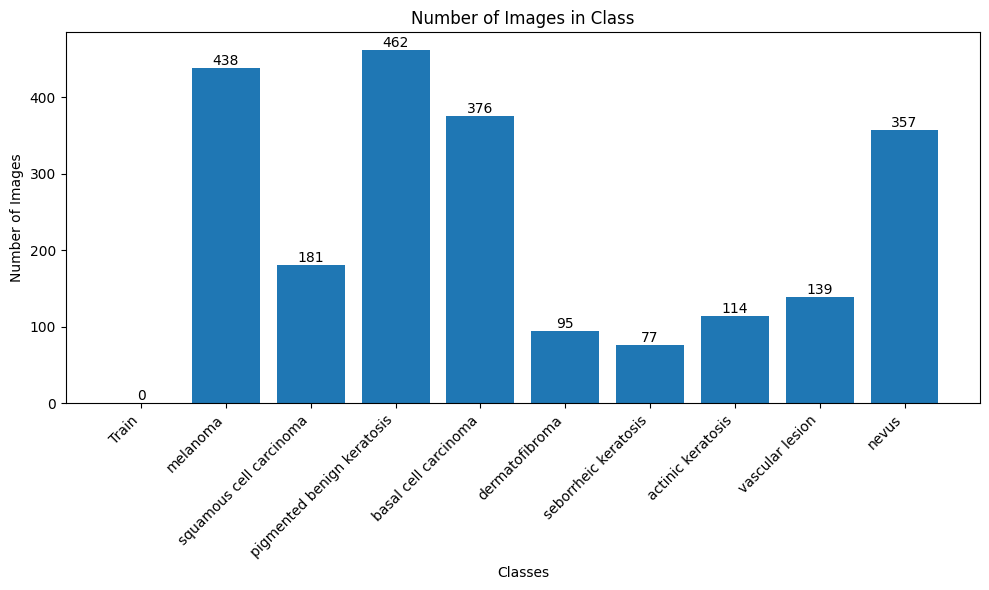

In [25]:
def count_images_in_folders(root_dir):
    image_count = {}

    for root, dirs, files in os.walk(root_dir):
        class_name = os.path.basename(root)
        image_count[class_name] = len([file for file in files if file.endswith(('jpg'))])

    return image_count

def plot_histogram(image_count):
    plt.figure(figsize = (10, 6))
    bars = plt.bar(range(len(image_count)), list(image_count.values()), align='center')
    plt.xticks(range(len(image_count)), list(image_count.keys()), rotation = 45, ha = 'right')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Class')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, '%d' % int(height), ha = 'center', va = 'bottom')

    plt.tight_layout()
    plt.show()

image_count = count_images_in_folders(data_dir_train)
plot_histogram(image_count)

There is a clear class imbalance present in the dataset. We need to use and augmentation strategy to remove the mismatch in data.

#### Which class has the least number of samples?
> seborrheic keratosis with 77 images.

#### Which classes dominate the data in terms proportionate number of samples?
> pigmented benign keratosis with 462 images.

### Using Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
!pip install Augmentor

In [28]:
import Augmentor

train_path = path + "/Train/"
print(train_path)

for i in class_names:
    p = Augmentor.Pipeline(train_path + i)
    p.rotate(probability = 0.7, max_left_rotation = 10, max_right_rotation = 10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0AA1561E40>: 100%|██████████| 500/500 [00:23<00:00, 21.30 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0A900DB9A0>: 100%|██████████| 500/500 [00:21<00:00, 22.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0A9182FC70>: 100%|██████████| 500/500 [00:24<00:00, 20.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E0A8A60FFD0>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0A90144AF0>: 100%|██████████| 500/500 [01:39<00:00,  5.02 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0A907A65F0>: 100%|██████████| 500/500 [00:23<00:00, 21.06 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E0B34815AB0>: 100%|██████████| 500/500 [00:48<00:00, 10.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E0A8A6320E0>: 100%|██████████| 500/500 [00:23<00:00, 21.38 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0A91E2DA20>: 100%|██████████| 500/500 [00:21<00:00, 22.80 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000414.jpg_7a56e3ab-69ac-4bd1-9627-a98ea845facb.jpg',
 '/content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000411.jpg_76f545c4-01b7-49d3-b520-342995f8cc77.jpg',
 '/content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011181.jpg_9fda0947-3df7-45b0-b541-58154b89e2fd.jpg',
 '/content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000288.jpg_4a8f0b35-f5a7-4f55-a087-48d008dbea17.jpg',
 '/content/drive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010000.jpg_867acb29-f3c5-4328-90d2

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()), columns = ['Path', 'Label'])

In [34]:
new_df['Label'].value_counts()

Label
melanoma                      500
squamous cell carcinoma       500
pigmented benign keratosis    500
basal cell carcinoma          500
dermatofibroma                500
seborrheic keratosis          500
actinic keratosis             500
vascular lesion               500
nevus                         500
Name: count, dtype: int64

In [35]:
for i in class_names:
    directory = path + '/Train'
    class_directory = pathlib.Path(directory)
    length = len(list(class_directory.glob(i + '/*.jpg')))

    directory_out = path + '/Train' + '/' + i + '/output/'
    class_directory_out = pathlib.Path(directory_out)
    length_out = len(list(class_directory_out.glob('*.jpg')))

    length_tot = length + length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Training Augmented Model

#### Training dataset

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [37]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Build model

In [38]:
model = Sequential()
model.add(Rescaling(1./255, input_shape = (180, 180, 3)))
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(256, kernel_size = (11, 11), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names), activation = 'softmax'))

#### Compile model with proper optimizer

In [39]:
learn_control = ReduceLROnPlateau(
    monitor = 'val_accuracy', patience = 5, verbose = 1, factor = 0.2, min_lr = 1e-7
)

model.compile(
  optimizer = optimizer,
  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics = ['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 41, 41, 128)      

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(
    train_ds,
    batch_size = batch_size,
    validation_data = validation_ds,
    epochs = epochs,
    callbacks = [learn_control]
)

Epoch 1/50
169/169 [==============================] - 672s 4s/step - loss: 2.0613 - accuracy: 0.1868 - val_loss: 1.8681 - val_accuracy: 0.2316 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 669s 4s/step - loss: 1.8868 - accuracy: 0.2545 - val_loss: 1.8968 - val_accuracy: 0.2970 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 667s 4s/step - loss: 1.7075 - accuracy: 0.3552 - val_loss: 1.6255 - val_accuracy: 0.3690 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 670s 4s/step - loss: 1.5768 - accuracy: 0.3893 - val_loss: 1.4801 - val_accuracy: 0.4254 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 668s 4s/step - loss: 1.5120 - accuracy: 0.4156 - val_loss: 1.3344 - val_accuracy: 0.4774 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 671s 4s/step - loss: 1.4586 - accuracy: 0.4345 - val_loss: 1.4366 - val_accuracy: 0.4298 - lr: 0.0010
Epoch 7/50
169/169 [==============================] - 669s 4s/st

**NOTE**: Time did not permit to run the model for all 50 ephocs, but still the accuracy is very good after 34 epochs. We see almost same training and validation accuracy. I would not be able to test this model since recompiling will take another day, but it would be a fair assumption that the model would perform very well.

### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes, underfitting and overfitting both have been taken care of. Yes class reblance helped achieve validation accuracy of over 85%.